# Lambda School Data Science Program Hires
Data was acquired via a raw count of Slack workspace #hired channel alerts.

In [1]:
import datetime

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
hires = pd.read_csv("lambda-ds-hires.csv", usecols=[0, 1],
                    parse_dates=["Hire Date"])
hires = hires.rename(columns={"Track": "ds_track", "Hire Date": "hire_date"})
hires.head()

,ds_track,hire_date
0,11,2020-09-23
1,16,2020-09-11
2,6,2020-10-07
3,11,2020-07-15
4,8,2020-09-09


So far, there have been 16 cohorts. It's no surprise that the first cohort has had the most hires as they've had plenty of time.
Ironically, the second cohort has had less than 10 hires despite being one of the earliest.

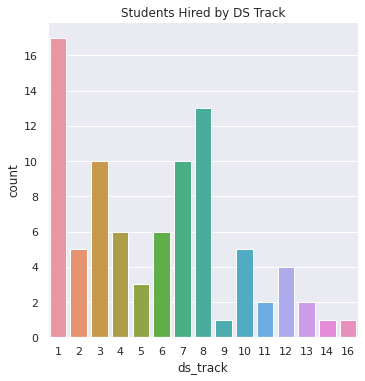

In [3]:
sns.set_theme()
catplot = sns.catplot(data=hires, x="ds_track", kind="count")
plt.title("Students Hired by DS Track")
catplot.savefig("hired_count.png");

### Bootstrapping Confidence Interval

I wanted to know what the average time to hire was, but with only 86 samples, bootstrapping and getting a confidence interval for means might be the easiest way to get a good feel for what the average time to hire is. I'm using an assumed program begin date as the starting point for each cohort given that I'm not sure if there are program length variations by track. My start date was Dec 2, 2019. Here I assume that a new cohort started every month, thus the main assumption is that DS1 started on February 05, 2019.

In [4]:
# When did DS1 begin?
ds11 = pd.Timestamp('2019-12-02')
average_days_per_month = round(365 / 12)
ten_months = pd.Timedelta(value=(average_days_per_month * 10), unit="days")
ds1 = ds11 - ten_months

ds1

Timestamp('2019-02-05 00:00:00')

In [5]:
def get_date(track: int) -> pd.Timestamp:
        """Gets the start of the track date based on track number"""
        ds1 = pd.Timestamp('2019-02-05')
        if track == 1:
            return ds1
        else:
            later_track = pd.Timedelta(value=(30 * (track-1)), unit="days")
            return ds1 + later_track

In [6]:
hires["estimated_start"] = hires["ds_track"].apply(get_date)
hires["days_to_hire"] = (hires["hire_date"] - hires["estimated_start"]).dt.days

hires.head()

,ds_track,hire_date,estimated_start,days_to_hire
0,11,2020-09-23,2019-12-02,296
1,16,2020-09-11,2020-04-30,134
2,6,2020-10-07,2019-07-05,460
3,11,2020-07-15,2019-12-02,226
4,8,2020-09-09,2019-09-03,372


Before bootstrapping, the average time to hire is ~277 days, with the median at ~283 days.

In [7]:
hires.describe()

,ds_track,days_to_hire
count,86.000000,86.000000
mean,5.709302,277.093023
std,3.791217,94.587106
min,1.000000,67.000000
25%,2.250000,212.250000
50%,6.000000,283.000000
75%,8.000000,351.750000
max,16.000000,460.000000


The distribution is relatively normal looking for days spent in the program before hire. I didn't use graduation as the starting point for days-to-hire, as some students were hired before graduating from the program

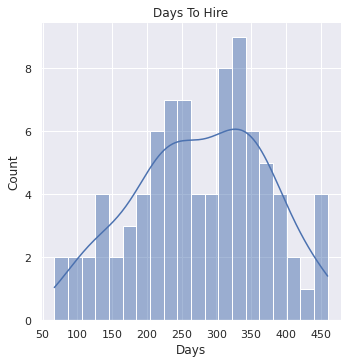

In [8]:
distplot = sns.displot(data=hires, x="days_to_hire", kde=True, bins=20)
plt.title("Days To Hire")
plt.xlabel("Days")
distplot.savefig("days_to_hire_dist.png");

In [9]:
np.random.seed(0)
means = [np.random.choice(hires["days_to_hire"], size=300).mean() for _ in range(10000)]
means = np.array(means)

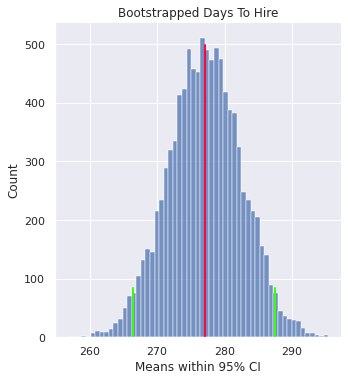

In [10]:
OUT_H = 85
IN_H = 500
LW = 2

bootstrapped = sns.displot(data=means)

plt.title("Bootstrapped Days To Hire")
plt.plot(np.full((IN_H,), means.mean()), np.arange(0, IN_H), color="#FE063A", lw=LW)
plt.plot(np.full((OUT_H,), np.quantile(means, 0.025)), 
         np.arange(0, OUT_H), color="#37FD12", lw=LW)
plt.plot(np.full((OUT_H,), np.quantile(means, 0.975)), 
         np.arange(0, OUT_H), color="#37FD12", lw=LW)
plt.xlabel("Means within 95% CI")

bootstrapped.savefig("bs_day_means.png");

In [11]:
print(f"Upper Bound: {np.quantile(means, .975)}")
print(f"Lower Bound: {np.quantile(means, .025)}")

Upper Bound: 287.5470833333333
Lower Bound: 266.4265833333333
